# Homework 3 (Due Oct. 11)
###### Brian Stampe

## 1. The occasionally dishonest casino

Imagine that you are employed by the Montana State Gaming Board, and you have received an anonymous tip suggesting that the dealer in the dice games that frequently occur at the Oxford is cheating.  In particular, the dealer is surreptitiously switching from a fair die to a loaded one (and back) with a certain probability.  In this game, the ante is a dollar.  you choose a number, the dealer rolls the die, and if it matches you get back 3 times your ante.  Otherwise, you lose your ante.  

You examine security camera footage from which you extracted the following dataset, with *states* describing whether the die was loaded, and rolls being the outcome of each die roll.

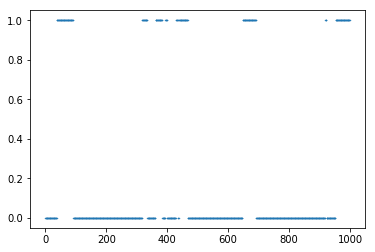

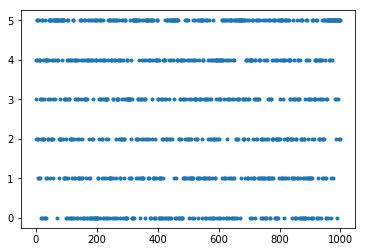

In [3]:
import pickle
import matplotlib.pyplot as plt

states,rolls = pickle.load(open('oxford.p','rb'))
plt.plot(states, '.', markersize=1)
plt.show()
plt.plot(rolls, '.')
plt.show()

### 1a. Training a HMM (20pts)
Assume that the dealer follows a Markov model
$$
P(S_{t+1}=s_k|S_t=s_j) = A_{jk}, s_j\in\{0,1\},s_k\in\{0,1\},
$$
where $s_j=0$ corresponds to use of the fair die, while $s_j=1$ means the die is loaded.  The outcome of the die roll follows a categorical distribution conditioned on which die was being used
$$
P(R_t=r|S_t=s_j) = E_{jr}, r_t\in\{0,1,2,3,4,5\}.
$$
Note that for convenience, the dealer is using a six-sided, zero-indexed die.

Train your model of the dealer's ruse by using your observations to find the maximum likelihood estimators for the transition matrix $A$ and the emission probabilities $E$.  

HINT: because the states are observed, training $A$ is equivalent to training a normal Markov model.  Similarly, training $E$ is equivalant to training a Naive Bayes model, where the state is the class and the die roll is the feature.

In [4]:
import numpy as np

m = len(states)
A = np.zeros((2,2))
E = np.zeros((2,6))

#! Compute the parameters of the transition and emission matrices.
def compute_transition(array, matrix): 
    for i in range(len(array)-1):
        if array[i] == 0 and array[i+1] ==0:
            matrix[0,0] += 1
        elif array[i] == 0 and array[i+1] ==1:
            matrix[0,1] += 1
        elif array[i] == 1 and array[i+1] ==0:
            matrix[1,0] += 1
        elif array[i] == 1 and array[i+1] ==1:
            matrix[1,1] += 1
    return matrix


compute_transition(states, A)

print ("prior probability of fair die: \n" , A[0,:].sum()/len(states))
A[0,:] /= A[0,:].sum()  # normalize transition matrix
A[1,:] /= A[1,:].sum()

def compute_emision(rolls, states, matrix):
    '''rolls is an array len of rolls, with value being \
    the value obtained from individual roll. states is an \
    array len of rolls, with value being die loaded or not.\
    matrix is an 2-D numpy array of zeros waiting to be filled\
    to count the likelihood of roll values for each state.'''
    for i in range(len(states)):
        matrix[states[i],rolls[i]] +=1        
    return matrix

def compute_emision_fair(rolls, states, matrix):
    '''altered emision matrix function that uses the knowledge of the fair die\
    being likely a 1/6 chance for each number. Actually performs worse on this 
    paticular task. Likely, because a five is less likely in the empirical \
    emision matrix than in the predefined 1/6 and therefore is harder
    to discern the difference between loaded and unloaded states.'''
    for i in range(len(states)):
        if states[i]==1:
            matrix[states[i],rolls[i]] +=1 
    matrix[0,:] = 1/6.         
    return matrix


compute_emision(rolls, states, E) 

count = 0
for i in range(len(states)):
    if states[i]==0:
        count +=1
count
E[0,:]=E[0,:]/count   #normalize emision matrix
E[1,:]=E[1,:]/(len(states)-count)
# Rewrite E with 1/6 for rolls of the fair die, see if this improves performance
#E = np.zeros((2,6))
#compute_emision_fair(rolls, states, E)
#E[1,:] /= E[1,:].sum()

print ('\nTransition Matrix: \n aka P(future_state|current_state) \n', A)
print ('\n Emision Matrix: \n aka P(roll|state)\n', E)

prior probability of fair die: 
 0.77

Transition Matrix: 
 aka P(future_state|current_state) 
 [[0.98831169 0.01168831]
 [0.0349345  0.9650655 ]]

 Emision Matrix: 
 aka P(roll|state)
 [[0.16623377 0.17792208 0.14155844 0.16883117 0.18701299 0.15844156]
 [0.0826087  0.06521739 0.12608696 0.09130435 0.11304348 0.52173913]]


### 1b. Determining when the house is cheating. (20pts)
Now that you know the cheating dealer's strategy, you decide that you want to catch the dealer in the act.  Play 1000 games of dice with the dealer, using the forward algorithm to determine when the dealer is cheating.  Recall that you now don't have access to the dealer's state, only the rolls!  Assume that the dealer starts using the fair die.  Report the probability that the dealer is using the loaded die at each of the 1000 rolls.

HINT: In the notation of Murphy, you are looking for $P(z_t=j|\mathbf{x}_{1:t})=\alpha_t(j)$, where $z_t=j\in\{0,1\}$ are the possible states and $\mathbf{x}_{1:t}$ are all the die rolls up to the current time.  The two step formula for computing this quantity can be found in Murphy Eqs. 17.44-17.47.



percent correct classification: 
 92.0 %


0.9150849150849151

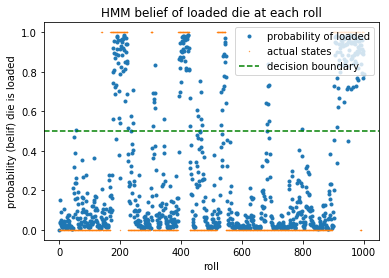

In [11]:
from pylab import *
def oxford(num_rolls,plotting,decision_boundary,bet):
    '''hidden markov model simulation of a dice game at oxford. Takes arguments num_rolls,
    plotting is a boolean True | False and decision_boundary which takes a decimal (0-1)
    probability which is interperated as what probability of fair we 'guess' is fair.
    bet is a boolean argument, which implements two different strategies to beat the house.
    The first strategy is bet 5 if you believe the die is loaded 
    (decision_boudary probability sets this) otherwise bet randomly 0-5. The other strategy
    is to be more conservative and bet only when you believe the die is loaded. In whihc
    case you bet 5'''
    
    def likelihood(state, roll):
        return E[state,roll]

    def prediction(state):
        return np.dot(state,A)

    possible_states = [0,1]
    possible_rolls = [0,1,2,3,4,5]

    alpha = [np.array([1.0,0.0])]# start by predicting fair die
    current_state = 0
    current_roll = np.random.choice(possible_rolls,p=E[0])

    states = [current_state]
    rolls = [current_roll]

    for g in range(num_rolls):

        ### This is the dealer's internal state, you can't use this information!
        current_state = np.random.choice(possible_states,p=A[current_state])
        states.append(current_state)
        ###

        ### This is the dealer's emission, you *can* use this information
        current_roll = np.random.choice(possible_rolls,p=E[current_state])
        rolls.append(current_roll)
        ###

        #! Implement the recursive forward algorithm to determine the probability 
        #! of being in the fair or loaded state for all rolls

        predict = prediction(alpha[g])
        #print (predict)
        #select what part of emision matrix we care about(i.e. grab whatever current roll is and both possible states)
        selected_emision = likelihood(possible_states,current_roll) 
        #print (selected_emision)
        ######3numerator = selected_emision*predict  
        #print (numerator)
        normilization = predict@selected_emision.T
        #normilization = np.dot(predict,selected_emision.T)
        #print (normilization)
        ######new_alpha = numerator/normilization
        #print (new_alpha)
        
        new_alpha = selected_emision*predict/normilization
        
        alpha.append(new_alpha)


    alpha = np.array(alpha) # turn into nice 2-d? array
    ###########################
    ####### % correct #########
    ###########################
    states=np.array(states)
    states

    right_predict_array = np.zeros(len(states))
    count = 0
    
     # if fair likeihood is > decision boundary, choose fair (dice type 0)
    states_decided = np.zeros(len(alpha[:,0]))
    for i in range(len(alpha[:,0])):
        if alpha[i,0] > decision_boundary:
            states_decided[i] = 0  #fair dice type
        else:
            states_decided[i] = 1  # loaded dice type

    
    for i in range(len(states)):
        if np.isclose(states[i],states_decided[i],atol=1e-2):
            right_predict_array[i] = 1
            count +=1
        else:
            right_predict_array[i]=0

    print ('\npercent correct classification: \n', np.round((100*count/len(states))),'%')
    
    ############################
    #BETTING STRATEGY IMPLEMTATION
    ############################
    if bet == True:
        
        money_made = 0
        
        for i in range(len(states)):
            if rolls[i] == 5 and states_decided[i] == 1:
                money_made +=3
            else:
                money_made -=1
    
        print ('\nIf I were to bet every roll and bet a five every time: \n', money_made)

    # OK I lost money betting a five every roll. This should be the maximum money I can make
    # if I have to bet each roll. The only other way I can maximize this is by deciding not to
    # bet when the die is fair. And then bet a five when the die is loaded. Furthermore, 
    # I can now manipulate my decision bounday such that I am conservative or not, since
    # not betting only has the practical downside of taking a lot of rolls before making any
    # money. 

        money_made = 0 
        for i in range(len(rolls)):
            if states_decided[i] == 1:
                if rolls[i] == 5:
                    money_made += 3
                else:
                    money_made -= 1
            
        print ('\nMoney made betting a five only when I believed it was loaded: \n', money_made)
        
    
    ###########################
    ############ PLOT ########
    #########################
    if plotting == True:
            
        
        fig = figure()
        ax = subplot(1,1,1)
        
        plot(alpha[:,1],'.', label='probability of loaded')
        plot(states, '.', markersize=.7, label='actual states')
        axhline(decision_boundary, linestyle='--', color = 'g', label='decision boundary')
        
        title('HMM belief of loaded die at each roll')
        legend(loc='upper right')
        xlabel('roll')
        ylabel('probability (belif) die is loaded')
        
    else:
        pass
    
    
    if bet==False:
        return count/len(states)
    if bet == True:
        return money_made
    
    
oxford(num_rolls=1000, plotting = True, decision_boundary = .5, bet = False)

###### Our HMM seems to correctly classify loaded or fair around 90% of the time. This is better than if we simply assumed fair every roll which would result in a 77% classification accuracy. Therefore, our enthusiasim in our increased accuracy should be tempered by what an unsophisticated approach would yield (77%). Furthermore, it seems a 1000 rolls is still too few to provide a consistent classification accuracy. One would assume a thousand rolls with only two states would be enough, however, because of the specifics of the transition matrix (if we were at fair we will likely be fair next roll (98%) and likewise for unfair (96%)) we can have long runs of either fair or loaded and this can prevent a 1000 rolls to be sufficient in approaching a consistent classification  accuracy. Two options, we could increase the number of rolls, or increase the number of games. I chose to do the latter. 


percent correct classification: 
 91.0 %

percent correct classification: 
 90.0 %

percent correct classification: 
 94.0 %

percent correct classification: 
 88.0 %

percent correct classification: 
 85.0 %

percent correct classification: 
 94.0 %

percent correct classification: 
 93.0 %

percent correct classification: 
 91.0 %

percent correct classification: 
 88.0 %

percent correct classification: 
 85.0 %

percent correct classification: 
 89.0 %

percent correct classification: 
 81.0 %

percent correct classification: 
 95.0 %

percent correct classification: 
 87.0 %

percent correct classification: 
 91.0 %

percent correct classification: 
 90.0 %

percent correct classification: 
 89.0 %

percent correct classification: 
 92.0 %

percent correct classification: 
 90.0 %

percent correct classification: 
 86.0 %

percent correct classification: 
 93.0 %

percent correct classification: 
 87.0 %

percent correct classification: 
 92.0 %

percent correct classification: 


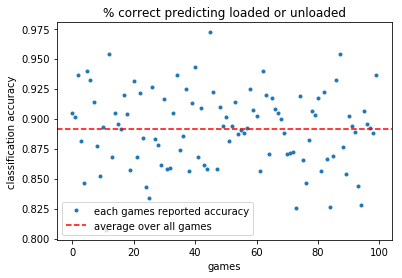

In [12]:
def addicted_to_oxford(number_games, decision_boundary, num_rolls):

    
    
    
    percent_correct_array = []
    
    for i in range(number_games):
        percent_correct_array.append(oxford(num_rolls=num_rolls,plotting=False, decision_boundary=decision_boundary, bet=False))
        #print (percent_correct_array)
    
    # By Linearity of Expectation
    percent_correct = np.average(percent_correct_array,axis=0) # average of average
    
    
    #print (percent_correct)   
    
    fig=figure()
    ax = subplot(1,1,1)
    
    plot(percent_correct_array, '.', label='each games reported accuracy')
    axhline(percent_correct, color='r',linestyle='--', label='average over all games')
    title('% correct predicting loaded or unloaded')
    xlabel('games')
    ylabel('classification accuracy')
    legend()
    show()
    return

addicted_to_oxford(number_games=100,decision_boundary=.5, num_rolls=1000)
    


### 1C (\*). Beating the house (10pts)
Describe a strategy for beating the house given all the information determined from the above two problems.  Show that your strategy will, in general, make money after 1000 rolls, either by mathematical proof, or by direct simulation. 

###### Assuming you have to bet every roll. First I would note, if you guess 5 everytime you will make the most money. However, this assumes that the dealer wont change his strategy once he catches on to you choosing 5. Likely, he would stop using the loaded die and you would go back to 1/6 chance of winning each roll and would end up loosing money after many rolls. Therefore, the strategy is to only choose six when you believe the die is loaded and switch when its unloaded. Then he is less likely to catch on to you only guessing six (although, he will still likely find it odd that you choose six 90% of the time he switches to a loaded die. We will let that lie for this experiment.

###### It seems impossible to consistenty beat the dealer if you HAVE to bet every roll. Therefore, a better strategy would be to bet only when you believe the die is loaded. 

In [13]:
# play a round
oxford(num_rolls=1000, plotting = False, decision_boundary = .5, bet = True)
# My percent classification goes down with such a strict decision_boundary, but I don't loose 
# as much money, becuase the consquences of guessing fair when loaded is basically time
# I loose less than I make less and therefore make more. 




percent correct classification: 
 93.0 %

If I were to bet every roll and bet a five every time: 
 -537

Money made betting a five only when I believed it was loaded: 
 264


264

In [14]:
# What if I play a bunch of rounds and manipulate the decision_boundary to find the best 
rounds = 50
num_rolls = 10000
money_made_array = []
decision_array = 1-(np.logspace(2.15,.35,rounds))**-1 # logspace to get lots of runs around a
# interesting zone of decision_boundary space, namely around .9-.99
for i in range(len(decision_array)):
    money_made_array.append(oxford(num_rolls=num_rolls, plotting = False, decision_boundary = decision_array[i], bet = True))




percent correct classification: 
 20.0 %

If I were to bet every roll and bet a five every time: 
 -849

Money made betting a five only when I believed it was loaded: 
 -842

percent correct classification: 
 27.0 %

If I were to bet every roll and bet a five every time: 
 127

Money made betting a five only when I believed it was loaded: 
 186

percent correct classification: 
 26.0 %

If I were to bet every roll and bet a five every time: 
 151

Money made betting a five only when I believed it was loaded: 
 260

percent correct classification: 
 26.0 %

If I were to bet every roll and bet a five every time: 
 -293

Money made betting a five only when I believed it was loaded: 
 -126

percent correct classification: 
 25.0 %

If I were to bet every roll and bet a five every time: 
 -225

Money made betting a five only when I believed it was loaded: 
 65

percent correct classification: 
 32.0 %

If I were to bet every roll and bet a five every time: 
 139

Money made betting a five 


percent correct classification: 
 89.0 %

If I were to bet every roll and bet a five every time: 
 -4865

Money made betting a five only when I believed it was loaded: 
 2748

percent correct classification: 
 89.0 %

If I were to bet every roll and bet a five every time: 
 -4897

Money made betting a five only when I believed it was loaded: 
 2733

percent correct classification: 
 87.0 %

If I were to bet every roll and bet a five every time: 
 -4353

Money made betting a five only when I believed it was loaded: 
 3081


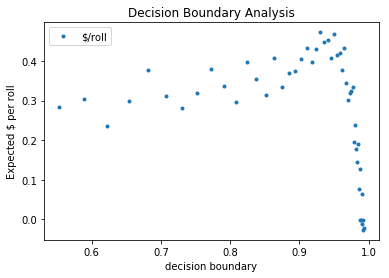


 Optimal decision boundary: 
 0.93


In [10]:

# Normalized by roll count
money_per_roll = np.array(money_made_array)/num_rolls
plot(decision_array, money_per_roll, '.', label='$/roll')
ylabel('Expected $ per roll')
xlabel('decision boundary')
title('Decision Boundary Analysis')
legend()
show()

#print (np.max(money_per_roll))
print ('\n Optimal decision boundary: \n', np.round(decision_array[np.argmax(money_per_roll)],2))


###### Looks like the the decision boundary that maximizes my return is from .9 to .95 belief in a loaded coin before I bet. This paticular analysis is done within the framework of the paticular betting game, betting a dollar and winning three if correct. Therefore, this optimal boundary would change if we drastically changed the cost/benefit of in/correctly guessing. If, for example, the benefit outweighed the cost by a factor of ten in lieu of three, we would shift this towards the less certain probabilities of a loaded coin, because we would not be penalized as much for incorrectly guessing. And similarly if we were to make the cost of guessing incorectly higher, we would only want to bet if we were very certain of it being a loaded coin. And at some point, around 1:2 dollar ratio of cost:reward we would not be able to make money, since we are only less than or equally likely to be right around 50% of the time since those are the odds of a 5 given loaded. 

## 2. The Kalman Filter

### 2a.  Tracking in 2D.  (30pts)
Imagine that we are monitoring the position of an aircraft, moving according to a so-called *constant velocity* model, in which:
$$
x_{t+1} = x_t + \Delta t u_t + \frac{\Delta t^2}{2} a_x^2
$$
$$
y_{t+1} = y_t + \Delta t v_t + \frac{\Delta t^2}{2} a_y^2
$$
$$
u_{t+1} = u_t + \Delta t a_x
$$
$$
v_{t+1} = v_t + \Delta t a_y,
$$
where $x$ and $y$ are the spatial coordinates in the map-plane (measured in km), $u$ and $v$ are the corresponding velocities measured in (km/s), and $a_x$ and $a_y$ are random accelerations due to buffeting by winds that are independent from one another.  $\Delta t=0.1 \mathrm{s}$ is the measurement interval, and the time step involved in computing the evolution of the aircraft state.   

Defining $\mathbf{z}_t=[x_t,u_t,y_t,v_t]$, we can write this model as
$$
\mathbf{z}_{t+1} = \mathbf{A}_t \mathbf{z}_t + \mathbf{\epsilon}_t,
$$
where $A$ is a *state transition matrix* given by
$$
\mathbf{A}_t = \begin{bmatrix} 1 & \Delta t & 0 & 0 \\
                    0 & 1 & 0 & 0  \\
                    0 & 0 & 1 & \Delta t \\
                    0 & 0 & 0 & 1 \end{bmatrix}.
$$

We assume that $\mathbf{\epsilon}_t = [\frac{\Delta t^2}{2} a_x^2, \Delta t a_x, \frac{\Delta t^2}{2} a_y^2, \Delta t a_y] \sim \mathcal{N}(0,\mathbf{Q}_t)$ is Gaussian noise with a zero mean, and $\mathbf{Q}_t$ is the covariance matrix
$$
\mathbf{Q}_t = a^2 \begin{bmatrix} 1/4 \Delta t^4 & 1/2\Delta t^3 & 0 &         0 \\
                        1/2 \Delta t^3 & \Delta t^2    & 0 &         0 \\
                        0 & 0 & 1/4 \Delta t^4 & 1/2\Delta t^3 \\
                        0 & 0 & 1/2 \Delta t^3 & \Delta t^2    \end{bmatrix},
$$
where $a=0.1 \mathrm{km/s}^2$ is a characteristic acceleration due to buffeting winds.

A global positioning unit fixed to the hull measures the coordinates $x$ and $y$.  At a fixed interval $\Delta t$ the unit returns an observation $\mathbf{y}_t = \mathbf{C}_t \mathbf{z}_t + \mathbf{\delta}_t$, where
$$
\mathbf{C}_t = \begin{bmatrix} 1 & 0 & 0 & 0 \\
                    0 & 0 & 1 & 0 \end{bmatrix}
$$
is the observation matrix, mapping the state variables to observations (essentially picking out the positions and ignoring the velocities since these are not directly measured) and $\mathbf{\delta}_t \sim \mathcal{N}(0,\mathbf{R}_t)$ is Gaussian observation noise with $\mathbf{R}_t$ the observation covariance
$$
R_t = \begin{bmatrix} 0.05^2 & 0 \\
                           0 & 0.05^2 \end{bmatrix},
$$
indicating that positions are observed with a standard deviation of 0.05 km.

We seek the posterior probability distribution of states $P(\mathbf{z}_t|\mathbf{y}_{1:t}) = \mathcal{N}(\mu_t,\Sigma_t)$ having made measurements up to and including the current time.  This distribution combines our knowledge of the aircraft motion with our observations, both of which are imperfect due to randomness in the physical process (random winds) and in the observation process (measurement error).  The Kalman filter provides a recursive formula to find the distribution mean $\mu_t$ and covariance $\Sigma_t$.

Apply the Kalman filter to the aircraft motion and resulting observations simulated below.  After applying the filter, **generate a plot of the true aircraft positions, the observations, and the position estimates generated by filtering**.  **Report both the final and initial covariance matrices, and describe whether our state estimates are becoming more or less certain as filtering proceeds.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

# Constants
a = 0.1   # Acceleration due to wind
dt = 0.1  # Interval for measurements

# Transition matrix
A = np.array([[1.0,dt,0.0,0.0],
              [0.0,1.0,0.0,0],
              [0.0,0.0,1.0,dt],
              [0.0,0.0,0,1.0]])

# Process noise covariance
Q = a**2*np.array([[1/4.*dt**4,1/2.*dt**3,         0,         0],
                   [1/2.*dt**3,     dt**2,         0,         0],
                   [         0,         0,1/4.*dt**4,1/2.*dt**3],
                   [         0,         0,1/2.*dt**3,     dt**2]])

# Observation matrix
C = np.array([[1,0,0,0],
              [0,0,1,0]])

# Observation covariance
R = np.array([[0.05**2,0],
              [0,0.05**2]])

### These are useful for sampling from normal distributions, but you
### don't need to worry about them.  
Q_cholesky = np.linalg.cholesky(Q)
R_cholesky = np.linalg.cholesky(R)
###
###

### The true state of the aircraft
### You do not have access to this information!
###
Z_true = [np.array([-1,0.1,-1,0.1])]
###
###
###

# Initial guess for aircraft position and velocity
mu_initial = np.array([0,0,0,0])

# Covariance matrix for this initial guess of position and velocity 
Sigma_initial = np.eye(4)*np.diag(np.array([1,1,1,1]))

# Lists for holding estimated states
mu = [mu_initial]
Sigma = [Sigma_initial]
Y = []


t=0
t_end = 20  #s
while t<t_end:
    
    ### Simulate the motion of the aircraft
    ### You do not have access to this information!
    ### Don't change!
    Z_0 = Z_true[-1]                                            
    Z_1 = np.dot(A,Z_0) + np.dot(Q_cholesky,np.random.randn(4))  # Move the plane forward in time
    Z_true.append(Z_1)
    Y_1 = np.dot(C,Z_1) + np.dot(R_cholesky,np.random.randn(2))  # Take a noisy measurement
    Y.append(Y_1)
    ###
    ###
    ###
    
    mu_previous = mu[-1] # Best state mean estimate from last time step
    Sigma_previous = Sigma[-1] # state covariance from last time step
    Y_current = Y[-1]  # Current observation
    
    # Prediction step
    #! Write code to predict
    mu_prior = np.dot(A,mu_previous) #! a) where the airplane will be according to the motion model
    Sigma_prior = np.dot(np.dot(A,Sigma_previous), A.T) + Q #! b) the covariance of that estimate
   
    # Update step
    #! Implement the formulae for the update step of the Kalman filter
    Kalman_gain_denominator_inverse = np.linalg.pinv(np.dot(np.dot(C,Sigma_prior),C.T) + R)
    Kalman_gain = (Sigma_prior@C.T)@Kalman_gain_denominator_inverse
    
    #! The posterior state mean estimate 
    mu_post = mu_prior + np.dot(Kalman_gain,(Y_current-np.dot(C,mu_prior)))
    #! The posterior covariance estimate
    Sigma_post =  np.dot((np.eye(4)-np.dot(Kalman_gain,C)),Sigma_prior)
    
    mu.append(mu_post)
    Sigma.append(Sigma_post)
    
    t+=dt



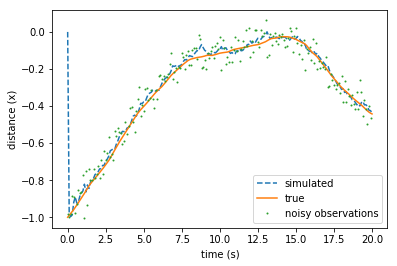

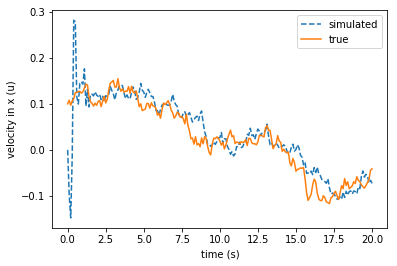

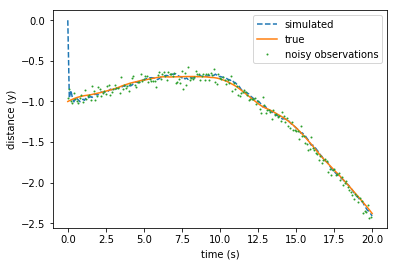

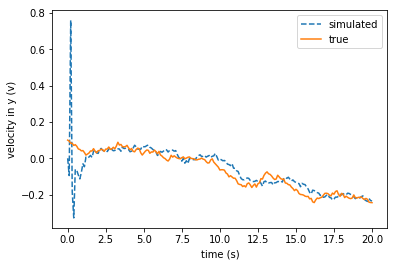

In [2]:
mu = np.array(mu) # convert list of arrays to array
Z_true = np.array(Z_true) # convert list of arrays to array
Y = np.array(Y)
#time = np.arange(0, (t_end+2*dt), step=dt) # create time array to plot against
time = np.linspace(0,t_end, len(mu))
fig = figure()

label = ['distance (x)','velocity in x (u)','distance (y)','velocity in y (v)']

for i in range(4):
    ax = subplot(1,1,1)
    plot(time, mu[:,i], '--', label='simulated')
    plot(time, Z_true[:,i], label ='true')
    if i == 0:
        plot(time[:-1], Y[:,0], '.', label='noisy observations', markersize = 2)
    if i == 2:
        plot(time[:-1], Y[:,1], '.', label='noisy observations', markersize = 2)
    ylabel(label[i])
    xlabel('time (s)')
    legend()
    show()


In [11]:
print ('\nThe initial covariance matrix: \n', Sigma[0])
print ('\nThe second covariance matrix: \n', Sigma[1])
print ('\nThe final covariance matrix: \n', Sigma[-1])


The initial covariance matrix: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

The second covariance matrix: 
 [[-0.01010026 -0.00100008  0.          0.        ]
 [-0.00100008  0.990099    0.          0.        ]
 [ 0.          0.         -0.01010026 -0.00100008]
 [ 0.          0.         -0.00100008  0.990099  ]]

The final covariance matrix: 
 [[0.04227345 0.00955726 0.         0.        ]
 [0.00955726 0.00437042 0.         0.        ]
 [0.         0.         0.04227345 0.00955726]
 [0.         0.         0.00955726 0.00437042]]


###### This shows our confidence in our simulated state is increasing through time. Our variances have decreased quite a bit. We have introduced uncertainty with our Velocity in x w/ respect to x as well as velocity in y with respect to y distance. These covariates are quite low, suggesting we have a lot of confidence in them, however, when plotted you can see our velocity in x and y seem to be quite far off from the actual. potentially inserting more uncertainty here could help us trust our observations more so that we could get back to closer to the true state. However, we would need observations of velocity to assimilate. Becuase we do not have velocity observations to assimilate we have to make due with x and y position estimates. It makes sense that on small scales we have mismodeled the velocity profile, as this is taken from changes in our modeled position (modeled smoothly) and our velocity profile gets perturbated by random flucations of noise (wind acceleration). Overall, these might balance out so in the long run we model the average velocity profile reasonably. 

### 2b (\*) Extended Kalman Filter. (20pts)
The Kalman filter only applies to observation models that are linear.  However, this is a restrictive assumption.  Consider the case where instead of tracking the plane with a GPS, we are tracking it with a radar, where the radar provides an estimate of range ($\rho_t$) and angle ($\theta_t$).  Assuming that the radar is located at $(x=0,y=0)$, the process of taking an observation then is:
$$
\mathbf{y}_t = h(\mathbf{z}_t) + \mathbf{g}_t
$$
where $h(\mathbf{z}_t)$ is the transformation from Cartesian to Polar coordinates
$$ h(\mathbf{z}_t) = \left[ \rho_t(\mathbf{z}_t), \theta_t(\mathbf{z_t})\right] = \left[\sqrt{x_t^2 + y_t^2},\mathrm{arctan2}(y_t,x_t)\right]. $$

An extended Kalman filter works by linearizing the observation process, which is to say that every time we see the product $\mathbf{C}_t\mathbf{z_t}$ in the Kalman filter algorithm, we replace it with $h(\mathbf{z_t})$, and every time we see $\mathbf{C}_t$ on its own, we replace it with the **Jacobian matrix** $H_{jac}(\mathbf{z}_t)$, which is given by
$$
H_{jac}(\mathbf{z}_t) = \begin{bmatrix} \frac{\partial \rho_t}{\partial x_t} & \frac{\partial \rho_t}{\partial u_t} & \frac{\partial \rho_t}{\partial y_t} & \frac{\partial \rho_t}{\partial v_t} \\
                          \frac{\partial \theta_t}{\partial x_t} & \frac{\partial \theta_t}{\partial u_t} & \frac{\partial \theta_t}{\partial y_t} & \frac{\partial \theta_t}{\partial v_t}
                          \end{bmatrix}
$$
Compute this Jacobian matrix and alter your Kalman Filter code to **implement the Extended Kalman Filter. Produce the same plots as in the previous section.**

Note that the code skeleton produces observations that are now in terms of $\rho_t$ and $\theta_t$ and the observational covariance $\mathbf{R}$ has been altered to account for the different magnitude of errors in these values.  Also note that **the complete EKF equations are given (in somewhat altered notation) in Murphy Eqs. 18.85-18.92.**



In [22]:

import numpy as np

# Constants
a = 0.1   # Acceleration due to wind
dt = 0.1  # Interval for measurements

# Transition matrix
A = np.array([[1.0,dt,0.0,0.0],
              [0.0,1.0,0.0,0],
              [0.0,0.0,1.0,dt],
              [0.0,0.0,0,1.0]])

# Process noise covariance
Q = a**2*np.array([[1/4.*dt**4,2.*dt**3,         0,         0],
                   [1/2.*dt**3,     dt**2,         0,         0],
                   [         0,         0,1/4.*dt**4,2.*dt**3],
                   [         0,         0,1/2.*dt**3,     dt**2]])


# Observation covariance
R = np.array([[0.1**2,0],
              [0,0.01**2]])

# Observation function
def h(X):
    R = np.sqrt(X[0]**2 + X[2]**2)
    theta = np.arctan2(X[2],X[0])
    return np.array([R,theta])

# Jacobian of observation function
def H_jac(X):
    #! Generate a function which returns the Jacobian of h
    Jacobian = np.zeros([2,4])
    
    Jacobian[0,0] = (0.5*(X[0]**2+X[2]**2)**-0.5)*(2*X[0]) # dp/dx
    Jacobian[0,2] = (0.5*(X[0]**2+X[2]**2)**-0.5)*(2*X[2])#dp/dy
    Jacobian[1,0] = -X[2]/((X[0]**2)+X[2]**2)#d0/dx
    Jacobian[1,2] = X[0]/((X[0]**2)+X[2]**2)#d0/dy
    
    return Jacobian
    

### These are useful for sampling from normal distributions, but you
### don't need to worry about them.  
Q_cholesky = np.linalg.cholesky(Q)
R_cholesky = np.linalg.cholesky(R)

### The true state of the aircraft
### You do not have access to this information!
###
Z_true = [np.array([-1,0.1,-1,0.1])]
###
###
###

# Initial guess for aircraft position and velocity
mu_initial = np.array([-1.0,0.1,-1.0,0.1])

# Covariance matrix for this initial guess of position and velocity 
Sigma_initial = np.eye(4)*1#np.diag(np.array([1,1,1,1]))

# Lists for holding estimated states
mu = [mu_initial]
Sigma = [Sigma_initial]
Y = []

t=0
t_end = 20.0
while t<t_end:
    
    ### Simulate the motion of the aircraft
    ### You do not have access to this information!
    ### Don't change!
    Z_0 = Z_true[-1]                                            
    Z_1 = np.dot(A,Z_0) + np.dot(Q_cholesky,np.random.randn(4))  # Move the plane forward in time
    Z_true.append(Z_1)
    Y_1 = h(Z_1) + np.dot(R_cholesky,np.random.randn(2))  # Take a noisy measurement
    Y.append(Y_1)
    ###
    ###
    ###
    
    mu_previous = mu[-1] # Best state estimate from last time step
    Sigma_previous = Sigma[-1] # state covariance from last time step
    Y_current = Y[-1]  # Current observation
    
    H = H_jac(mu_previous)
    
    # Prediction step
    #! Write code to predict
    mu_prior = np.dot(A,mu_previous) #! a) where the airplane will be according to the motion model
    Sigma_prior = np.dot(np.dot(A,Sigma_previous), A.T) + Q #! b) the covariance of that estimate
   
    # Update step
    #! Implement the formulae for the update step of the Kalman filter
    Kalman_gain_denominator_inverse = np.linalg.pinv(np.dot(np.dot(H,Sigma_prior),H.T) + R)
    #Kalman_gain = np.dot(np.dot(Sigma_prior, H.T), Kalman_gain_denominator)
    Kalman_gain = (Sigma_prior@H.T)@Kalman_gain_denominator_inverse
    
    I = Y_current - h(mu_prior)
    #! The posterior state mean estimate 
    mu_post = mu_prior + np.dot(Kalman_gain,I)
    #! The posterior covariance estimate
    Sigma_post =  np.dot((np.eye(4)-np.dot(Kalman_gain,H)),Sigma_prior)
      
    mu.append(mu_post)
    Sigma.append(Sigma_post)
    
    t+=dt



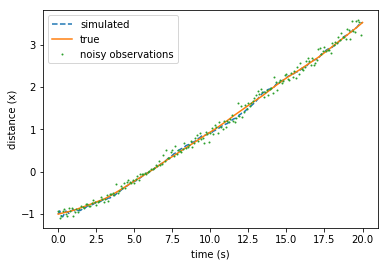

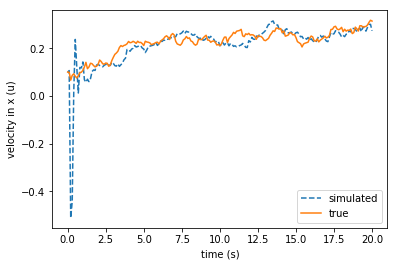

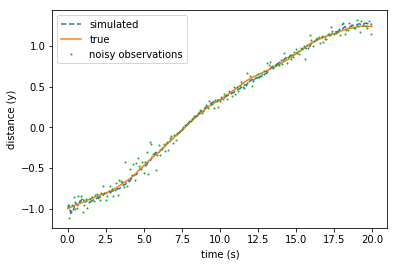

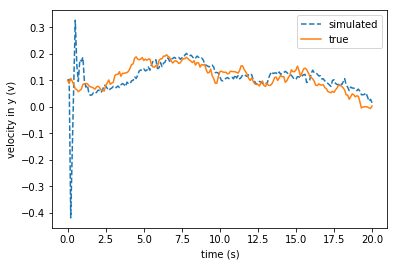

In [23]:
from pylab import *

mu = np.array(mu) # convert list of arrays to array
Z_true = np.array(Z_true) # convert list of arrays to array
Y = np.array(Y)
#time = np.arange(0, (t_end+2*dt), step=dt) # create time array to plot against
time = np.linspace(0,t_end, len(mu))
fig = figure()

### convert from polar to cartesian  ####
### makes plotting on same graph easy ###
Y_cartesian = np.empty_like(Y)
for i in range(len(Y)):
    Y_cartesian[i,0] = Y[i,0]*np.cos(Y[i,1])
    Y_cartesian[i,1] = Y[i,0]*np.sin(Y[i,1])
####
####

label = ['distance (x)','velocity in x (u)','distance (y)','velocity in y (v)']

for i in range(4):
    ax = subplot(1,1,1)
    plot(time, mu[:,i], '--', label='simulated')
    plot(time, Z_true[:,i], label ='true')
    if i == 0:
        plot(time[:-1], Y_cartesian[:,0], '.', label='noisy observations', markersize = 2)
    if i == 2:
        plot(time[:-1], Y_cartesian[:,1], '.', label='noisy observations', markersize = 2)
    ylabel(label[i])
    xlabel('time (s)')
    legend()
    show()

In [24]:
print ('The assumed first covariance matrix: \n', Sigma[0])
print ('The second covariance matrix: \n', Sigma[1])
print ('\nThe final covariance matrix: \n', Sigma[-1])


The assumed first covariance matrix: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
The second covariance matrix: 
 [[5.05096061e-03 5.00195005e-04 4.85100020e-03 4.80392990e-04]
 [5.00119990e-04 9.90246064e-01 4.80320946e-04 4.75660288e-05]
 [4.85100020e-03 4.80392990e-04 5.05096061e-03 5.00195005e-04]
 [4.80320946e-04 4.75660288e-05 5.00119990e-04 9.90246064e-01]]

The final covariance matrix: 
 [[0.00119047 0.00090917 0.00033903 0.00019691]
 [0.00081435 0.00122179 0.00019126 0.0001831 ]
 [0.00033943 0.00020438 0.0004048  0.00043274]
 [0.00018575 0.0001841  0.00036952 0.00079736]]


###### We are becoming (in general) more confident about our state estimates as we proceed. However, some (co)variances seem to spike later in the run, this is likely due to the weird behavior arctan in the observations to model matrix (H). 